In [1]:
# 주피터 가로로 넓게 쓰기
from IPython.core.display import display, HTML  
display(HTML(""))

In [2]:
import pandas as pd
import numpy as np
import os

import time 
import datetime as dt
from datetime import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import LabelEncoder

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, GroupKFold

# ML Library 
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import mean_absolute_error

from imblearn.over_sampling import SMOTE

from imblearn.combine import SMOTETomek # 오버 샘플링 성능 비교용 
from imblearn.under_sampling import TomekLinks

from adamp import AdamP
from tensorflow_addons.optimizers import AdamW

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GRU, Dropout, Dense, Conv1D
from tensorflow.keras import models

# TPOT : Automatic ML library that automatically enables feature selection and Hyperparameter learning based on multiple machine learning models 
from tpot import TPOTClassifier

print("Setup Complete")

Setup Complete


TPOT reference site : https://machinelearningmastery.com/tpot-for-automated-machine-learning-in-python/

In [3]:
path = "/home/kym/ML/input/kamp/대회 과제"
os.chdir(path)
model_path = path

df = pd.read_csv('melting_tank_mod.csv', encoding='cp949')

feature = [
    f for f in df.columns if f not in ("NUM")
]

df = df[feature]
df['STD_DT'] = df['STD_DT'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S', errors='coerce'))
df.set_index('STD_DT', inplace=True)

df.to_csv('/home/kym/ML/input/kamp/대회 과제/melting_tank_final.csv', index=False)
df.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
STD_DT,,,,
2020-03-04,48.9,11.6,631,1
2020-03-04,43.3,7.8,609,1
2020-03-04,46.4,15.4,608,1
2020-03-04,37.9,21.2,606,1
2020-03-04,79.8,173.6,604,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835200 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:00
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MELT_TEMP    835200 non-null  float64
 1   MOTORSPEED   835200 non-null  float64
 2   MELT_WEIGHT  835200 non-null  int64  
 3   TAG          835200 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 31.9 MB


In [5]:
# 표준 편차가 큰 feature 인 재료의 질량은 관찰 그래프를 통해 극히 영향도가 미미한 것을 알았기에 제외하고, 탱크 온도와 모터 속도만으로 학습함. 
df.describe().T.style.bar(subset=['mean'], color='#205ff2').background_gradient(subset=['std'], cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
MELT_TEMP,835200.000000,50.920062,12.827752,30.800000,43.000000,46.900000,50.200000,83.200000
MOTORSPEED,835200.000000,45.978287,63.943641,0.000000,11.900000,16.800000,21.800000,180.400000
MELT_WEIGHT,835200.000000,414.582481,317.234065,0.000000,186.000000,382.000000,579.000000,2820.000000
TAG,835200.000000,0.787994,0.408729,0.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
X = df.drop(['MELT_WEIGHT', 'TAG'], axis=1)
y = df['TAG']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [8]:
smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)
x_train_over, y_train_over = smoteto.fit_resample(x_train, y_train)

print("SMOTE 적용 전 학습용 피처 / 라벨 세트: ", x_train.shape, y_train.shape)
print("SMOTE 적용 후 학습용 피처 / 라벨 세트: ", x_train_over.shape, y_train_over.shape)
print("SMOTE 적용 후 라벨 값 분포: \n", pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처 / 라벨 세트:  (584640, 2) (584640,)
SMOTE 적용 후 학습용 피처 / 라벨 세트:  (920935, 2) (920935,)
SMOTE 적용 후 라벨 값 분포: 
 1    460688
0    460247
Name: TAG, dtype: int64


In [9]:
def process_data(df, label, window_size):
    feature_list = []
    label_list = []
    
    for i in range(len(df) - window_size):
        feature_list.append(np.array(df.iloc[i : i + window_size]))
        label_list.append(np.array(label.iloc[i + window_size]))
        
    return np.array(feature_list), np.array(label_list)

In [10]:
# dataframe
x_train_over = pd.DataFrame(x_train_over, columns=['MELT_TEMP', 'MOTORSPEED'])
y_train_over = pd.DataFrame(y_train_over, columns=['TAG'])

In [11]:
# window size = 10
train_feature, train_label = process_data(x_train_over, y_train_over, 10)
train_feature.shape, train_label.shape

((920925, 10, 2), (920925, 1))

In [12]:
x_test = pd.DataFrame(x_test, columns=['MELT_TEMP', 'MOTORSPEED'])

In [13]:
test_feature, test_label = process_data(x_test, y_test, 10)
test_feature.shape, test_label.shape

((250550, 10, 2), (250550,))

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.3)
x_train.shape, x_valid.shape

((644647, 10, 2), (276278, 10, 2))

### Model

In [15]:
model = Sequential()
model.add(GRU(64,
              input_shape=(train_feature.shape[1], train_feature.shape[2]),
              activation='tanh',
              return_sequences=True)
         )
model.add(tf.keras.layers.Dropout(0.2))
model.add(GRU(16,
              activation='tanh',
              return_sequences=True)
         )
model.add(tf.keras.layers.Dropout(0.2))
model.add(GRU(4,
              activation='tanh',
              return_sequences=False)
         )
model.add(Dense(1, activation='sigmoid'))

2022-11-07 19:29:02.289323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 19:29:02.308317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 19:29:02.308453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 19:29:02.309024: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
# Aactivation function 

# step = tf.Variable(0, trainable=False)
# schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
#     [10000, 15000], [1e-0, 1e-1, 1e-2])
# # lr and wd can be a function or a tensor
# lr = 1e-3 * schedule(step)
# wd = lambda: 1e-4 * schedule(step)

# AdamW

In [18]:
# 현실 고려 시 FN (음성으로 예측했는데 실제로 양성인 것 = 정상 (1) 으로 예측했는데 실제로 불량 (0) 인 것) 을 중점적으로 개선해야 한다. 

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adamax(), metrics=[tf.keras.metrics.AUC(curve='ROC')])
early_stop = EarlyStopping(monitor='val_loss', patience=5, min_delta = 0.005)
filename = os.path.join(model_path, 'melting_tank_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=2, save_best_only=True, mode='auto')

In [19]:
history = model.fit(x_train, y_train,
                   epochs=20,
                   batch_size=64,
                   validation_data=(x_valid, y_valid),
                   callbacks=[early_stop, checkpoint])

Epoch 1/20


2022-11-07 20:07:18.429394: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-11-07 20:07:18.526483: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10064/10073 [============================>.] - ETA: 0s - loss: 0.4205 - auc: 0.8529
Epoch 00001: val_loss improved from inf to 0.41788, saving model to /home/kym/ML/input/kamp/대회 과제/melting_tank_checkpoint.h5
10073/10073 [==============================] - 56s 5ms/step - loss: 0.4205 - auc: 0.8529 - val_loss: 0.4179 - val_auc: 0.8543
Epoch 2/20
10067/10073 [============================>.] - ETA: 0s - loss: 0.4112 - auc: 0.8548
Epoch 00002: val_loss improved from 0.41788 to 0.40985, saving model to /home/kym/ML/input/kamp/대회 과제/melting_tank_checkpoint.h5
10073/10073 [==============================] - 55s 5ms/step - loss: 0.4112 - auc: 0.8548 - val_loss: 0.4099 - val_auc: 0.8552
Epoch 3/20
10072/10073 [============================>.] - ETA: 0s - loss: 0.4087 - auc: 0.8556
Epoch 00003: val_loss improved from 0.40985 to 0.40819, saving model to /home/kym/ML/input/kamp/대회 과제/melting_tank_checkpoint.h5
10073/10073 [==============================] - 57s 6ms/step - loss: 0.4087 - auc: 0.8556 - 

In [20]:
pred = model.predict(test_feature)

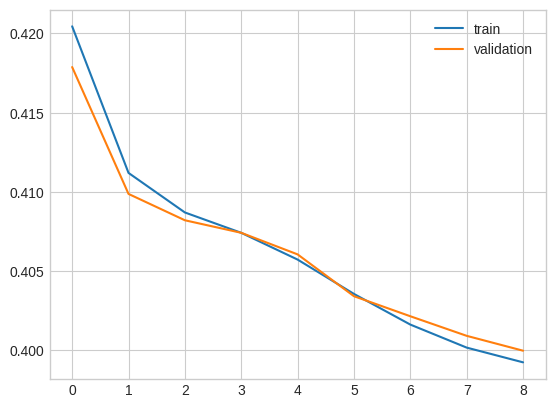

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [22]:
pred_df = pd.DataFrame(pred, columns=['TAG'])
pred_df['TAG'] = pred_df['TAG'].apply(lambda x: 1 if x >= 0.5 else 0)

In [23]:
# 1 정상, 0 불량
pred_df['TAG'].value_counts()

1    235372
0     15178
Name: TAG, dtype: int64

In [24]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        1 # print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

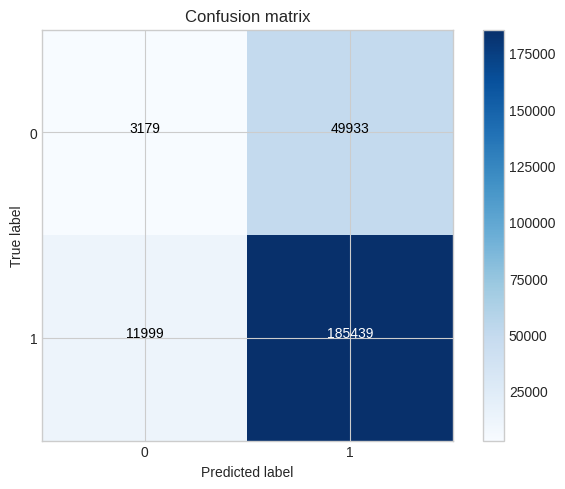

In [25]:
# 연속된 공정은 실제 불량을 정상으로 예측하는 FN 을 줄여야 함. 실제 정상을 불량으로 예측 시 설비를 정지시키는 수준이지만, 실제 불량을 정상 예측할 경우 다음 공정까지
# 투입되는 모든 비용을 망치게 된다. 따라서 재현율 (recall) 중점으로 봐야 함. 

classify = confusion_matrix(test_label, pred_df)

plt.figure()
plot_confusion_matrix(classify, classes=[0, 1], title='Confusion matrix')
plt.show()

In [26]:
print(classify)

[[  3179  49933]
 [ 11999 185439]]


In [27]:
p = precision_score(test_label, pred_df)
print("precision: %0.4f" %p)
r = recall_score(test_label, pred_df)
print("recall: %0.4f" %r)
f1 = f1_score(test_label, pred_df)
print("f1-score: %0.4f" %f1)
acc = accuracy_score(test_label, pred_df)
print("accuracy: %0.4f" %acc)

precision: 0.7879
recall: 0.9392
f1-score: 0.8569
accuracy: 0.7528


#### 참고 : TPOTC 구동 코드 (시간 매우 오래 걸림.) 

In [ ]:
# tpotc = TPOTClassifier(
#                         generations=100, 
#                         population_size=100, 
#                         scoring=['r2', 'accuracy'], 
#                         cv=5,
#                         verbosity=1, 
#                         n_jobs=-1, 
#                         random_state=42, 
#                         config_dict='TPOT light')
# tpotc.fit(x_train, y_train)

In [ ]:
# print("\nBest Pipeline steps:", end='\n')

# for idx, (name, transform) in enumerate(tpotc.fitted_pipeline_.steps, start=1):
#     print(f"{idx}. {transform}")

# tpotc.fitted_pipeline_.steps[-1][1] # get the best model

In [ ]:
# print(tpotc.score(x_test, y_test))
# tpotc.export('tpot_exported_pipeline.py')